<a href="https://colab.research.google.com/github/jayshrivastava0/Journey-Through-Projects/blob/main/GAN_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
import glob
import imageio
import os
import PIL
from tqdm import tqdm
from IPython import display
import time

In [28]:
(train_img, train_label), (test_img, test_label) = tf.keras.datasets.mnist.load_data()

In [29]:
train_images = train_img.reshape(train_img.shape[0], 28,28, 1).astype('float32') # (reshape[6000,28,28,1] if there are 6000 images in the dataset)
train_images = (train_images - 127.5)/127.5   # normalizing the images from -1 to 1

In [30]:
len(train_images)

60000

In [31]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BATCH_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [33]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape = (100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256)

  model.add(tf.keras.layers.Conv2DTranspose(128,(5,5), strides = (1,1), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 7,7,128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())


  model.add(tf.keras.layers.Conv2DTranspose(64,(5,5), strides = (2,2), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 14,14,64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())


  model.add(tf.keras.layers.Conv2DTranspose(1,(5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh'))
  assert model.output_shape == (None, 28,28,1)

  return model

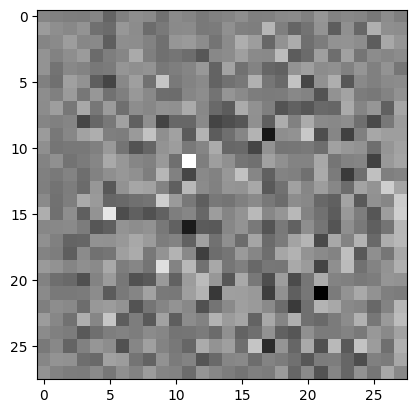

In [34]:
# from keras.engine.sequential import training
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [35]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [36]:
 def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64,(5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))


  model.add(tf.keras.layers.Conv2D(128,(5,5), strides = (2,2), padding = 'same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  return model

In [37]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49954826]], shape=(1, 1), dtype=float32)


In [38]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [39]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [40]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [41]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [44]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [45]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [49]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1,seed)

    if (epoch - 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)

In [50]:
from tensorflow.python.training import training
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5, cmap='gray')
    plt.axis('off')
  plt.show()

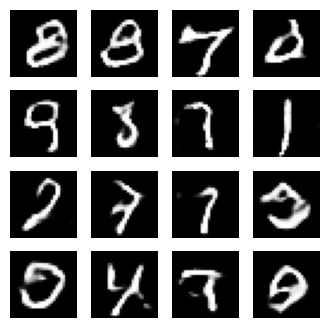

In [51]:
train(train_dataset, EPOCHS)